В этом файле представленно исследование по сессиям. С идеей разделить их на положительные и негативные.

In [57]:
import os
import psutil
from __future__ import print_function

pid = os.getpid()
python_process = psutil.Process(pid)
memoryUse = python_process.memory_info()[0]/2.**30  # memory use in GB...I think
print('memory use:', memoryUse, 'GB')
print('cpu % used:', psutil.cpu_percent())
print('memory % used:', psutil.virtual_memory()[2])

memory use: 4.881553649902344 GB
cpu % used: 1.5
memory % used: 10.6


In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [3]:
df = pd.read_parquet('./data_files/logs_df_2024-08-05.parquet', engine='pyarrow')

In [4]:
users = df['user_id'].unique()[:10000]
df = df[df['user_id'].isin(users)]

In [5]:
df_video = pd.read_parquet('./data_files/video_stat.parquet', engine='pyarrow')

In [77]:
all_data = pd.merge(df, df_video, how='inner', left_on='video_id', right_on='video_id')

In [78]:
all_data.shape

(319207, 48)

In [79]:
all_data = all_data[['event_timestamp', 'user_id', 'video_id', 'watchtime', 'v_total_comments', 'v_year_views', 'v_likes', 'v_dislikes', 'v_duration', 'title',
                     'category_id', 'author_id']]

In [80]:
def create_long_watch(row):
  if row['v_duration'] <= 300 and row['watchtime'] >= 30:
    return 1
  elif row['watchtime'] >= row['v_duration'] * 0.25:
    return 1
  return 0

all_data['long_watch'] = all_data[['watchtime', 'v_duration']].apply(lambda row: create_long_watch(row), axis=1)

In [81]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319207 entries, 0 to 319206
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype                                
---  ------            --------------   -----                                
 0   event_timestamp   319207 non-null  datetime64[ms, pytz.FixedOffset(180)]
 1   user_id           319207 non-null  object                               
 2   video_id          319207 non-null  object                               
 3   watchtime         319207 non-null  int64                                
 4   v_total_comments  319207 non-null  uint64                               
 5   v_year_views      319207 non-null  uint64                               
 6   v_likes           319207 non-null  uint64                               
 7   v_dislikes        319207 non-null  uint64                               
 8   v_duration        319207 non-null  float64                              
 9   title             319207 n

In [82]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(dtype=np.uint64)

for col in ['user_id', 'video_id', 'author_id']:
    all_data[col] = oe.fit_transform(all_data[[col]])

In [83]:
all_data

,event_timestamp,user_id,video_id,watchtime,v_total_comments,v_year_views,v_likes,v_dislikes,v_duration,title,category_id,author_id,long_watch
0,2024-08-05 12:12:32+03:00,6766,2496,32,0,1128,1,0,2564.629,Сериал Чёрный список - 1 сезон 18 серия / The...,Сериалы,5003,0
1,2024-08-05 18:30:15+03:00,4464,18201,340,7,61676,85,5,3900.134,Сериал Пацаны 4 сезон 1 серия / The Boys HDRezka,Сериалы,3484,0
2,2024-08-05 12:35:16+03:00,3300,31992,12,12,1274,66,0,1793.814,РЖАВАЯ МОЛОДОСТЬ ИКАРУС 280,Авто-мото,12346,0
3,2024-08-05 20:48:51+03:00,6649,11047,2460,0,6382,13,0,3147.329,Бесстыжие 3 сезон 7 серия «Долгий путь домой» ...,Сериалы,5867,1
4,2024-08-05 05:19:19+03:00,4564,46495,87,0,15924,15,0,822.699,"Паровозик Титипо, 1 сезон, 3 серия. Первый рей...",Мультфильмы,6130,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
319202,2024-08-05 14:20:56+03:00,1216,3766,0,0,892,3,0,31.999,25.09.2023 - Пресс нижний. Подъём ног - 15 раз...,Спорт,3539,0
319203,2024-08-05 15:40:54+03:00,7243,27316,0,0,828,0,0,13.767,Забавные и не только моменты из наших видосико...,Видеоигры,9391,0
319204,2024-08-05 00:28:07+03:00,6461,26375,0,0,1063,1,0,49.234,1000003715.mp4,Разное,3171,0
319205,2024-08-05 03:39:06+03:00,8359,4695,171,1,125,2,0,175.019,Анапа. Теплое море и жаркое солнце — идеальный...,Путешествия,12425,1


In [91]:
def long_watch(row):
    return row.sum() / len(row)

long_watch_share = all_data[['long_watch', 'user_id']].groupby('user_id').apply(long_watch)

/tmp/ipykernel_97839/2247260172.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_watch_share = all_data[['long_watch', 'user_id']].groupby('user_id').apply(long_watch)


In [92]:
long_watch_share.describe().T

,count,mean,std,min,25%,50%,75%,max
long_watch,9206.0,0.469396,0.359076,0.0,0.102785,0.5,0.777778,1.0
user_id,9206.0,4602.500000,2657.687623,0.0,2301.250000,4602.5,6903.750000,9205.0


In [110]:
long_watch_share_cl = long_watch_share[(long_watch_share['long_watch'] >= 0.5) & (long_watch_share['long_watch'] <= 0.78)]
sessions_id = long_watch_share_cl.index
print(sessions_id.shape)
print(round(sessions_id.shape[0] / long_watch_share.shape[0], 2))

(2413,)
0.26


In [103]:
video_count = all_data[all_data['user_id'].isin(sessions_id)][['video_id', 'user_id']].groupby('user_id').count()

In [104]:
video_count.describe().T

,count,mean,std,min,25%,50%,75%,max
video_id,2413.0,55.079155,1857.248746,2.0,4.0,9.0,20.0,91215.0


In [105]:
video_count_cl = video_count[(video_count['video_id'] >= 9) & (video_count['video_id'] <= 20)]

<Axes: ylabel='Count'>

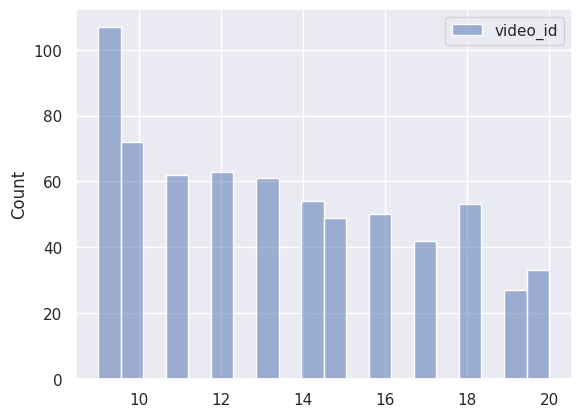

In [106]:
sns.histplot(video_count_cl, bins=20)

In [111]:
sessions_id = np.concatenate((sessions_id.values, video_count.index.values), axis=0)
print(round(video_count_cl.shape[0] / video_count.shape[0], 2))

0.28


In [121]:
print(sessions_id.shape)
print(round(sessions_id.shape[0] / all_data.shape[0], 2))

(4826,)
0.02


# Session research

In [116]:
all_data['session_ok'] = 0
all_data[all_data['user_id'].isin(sessions_id)]['session_ok'] = 1
all_data.head()

/tmp/ipykernel_97839/3410015033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data[all_data['user_id'].isin(sessions_id)]['session_ok'] = 1


,event_timestamp,user_id,video_id,watchtime,v_total_comments,v_year_views,v_likes,v_dislikes,v_duration,title,category_id,author_id,long_watch,session_ok
0,2024-08-05 12:12:32+03:00,6766,2496,32,0,1128,1,0,2564.629,Сериал Чёрный список - 1 сезон 18 серия / The...,Сериалы,5003,0,0
1,2024-08-05 18:30:15+03:00,4464,18201,340,7,61676,85,5,3900.134,Сериал Пацаны 4 сезон 1 серия / The Boys HDRezka,Сериалы,3484,0,0
2,2024-08-05 12:35:16+03:00,3300,31992,12,12,1274,66,0,1793.814,РЖАВАЯ МОЛОДОСТЬ ИКАРУС 280,Авто-мото,12346,0,0
3,2024-08-05 20:48:51+03:00,6649,11047,2460,0,6382,13,0,3147.329,Бесстыжие 3 сезон 7 серия «Долгий путь домой» ...,Сериалы,5867,1,0
4,2024-08-05 05:19:19+03:00,4564,46495,87,0,15924,15,0,822.699,"Паровозик Титипо, 1 сезон, 3 серия. Первый рей...",Мультфильмы,6130,0,0


In [117]:
all_data.sort_values(by='user_id')

,event_timestamp,user_id,video_id,watchtime,v_total_comments,v_year_views,v_likes,v_dislikes,v_duration,title,category_id,author_id,long_watch,session_ok
112723,2024-08-05 17:04:12+03:00,0,52256,1231,1,5410,16,1,1275.169,Гриффины 10 сезон 3 серия,Сериалы,9766,1,0
274167,2024-08-05 14:59:01+03:00,0,33514,997,0,5933,19,1,1296.225,Гриффины 10 сезон 1 серия,Сериалы,9766,1,0
145959,2024-08-05 05:26:05+03:00,0,41420,1262,0,2533,8,0,1303.745,Гриффины 9 сезон 15 серия,Сериалы,9766,1,0
17124,2024-08-05 17:30:58+03:00,0,34975,1273,0,7186,19,0,1298.305,Гриффины 10 сезон 4 серия,Сериалы,9766,1,0
138963,2024-08-05 14:48:23+03:00,0,33514,251,0,5933,19,1,1296.225,Гриффины 10 сезон 1 серия,Сериалы,9766,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267914,2024-08-05 18:05:49+03:00,9203,54968,0,0,1329,0,0,55.900,"вышивка-стежка, джинсовая переделка",Хобби,4910,0,0
208629,2024-08-05 18:21:05+03:00,9203,26259,0,0,790,1,0,18.192,1000001725.mp4,Развлечения,9518,0,0
165431,2024-08-05 18:22:52+03:00,9203,45393,0,0,1690,1,0,15.067,1000248514.mp4,Развлечения,4747,0,0
8931,2024-08-05 11:35:26+03:00,9204,6429,3,5,13796157,21,2,57.707,Как формировать привычки,Лайфстайл,9891,0,0


In [122]:
all_data['session_ok'].value_counts()

session_ok
0    319207
Name: count, dtype: int64

In [118]:
perfect_sessions = all_data[all_data['session_ok']==1].groupby('user_id').apply(list)

/tmp/ipykernel_97839/4036058345.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  perfect_sessions = all_data[all_data['session_ok']==1].groupby('user_id').apply(list)


In [119]:
perfect_sessions

,event_timestamp,user_id,video_id,watchtime,v_total_comments,v_year_views,v_likes,v_dislikes,v_duration,title,category_id,author_id,long_watch,session_ok
user_id,,,,,,,,,,,,,,
